Autor: Bruno Almeida da Silva - Matrícula: 190061197


# Oscilador Harmônico Forçado

Este trabalho é um exemplo da aplicação do modelo ARX de Identificação de Sistemas para resolver a solução transiente de um Oscilador Harmônico Forçado em dois regimes distintos:
    
1. A Estimação dos parâmetros foi feita no regime de Subamortecimento;
2. Validou-se o modelo no regime de Superamortecimento.
    
As soluções foram retiradas da [Wikipedia](https://en.wikipedia.org/wiki/Harmonic_oscillator).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from control import *
%matplotlib inline

In [3]:
sns.set_color_codes(palette='dark')
sns.set(style="whitegrid")

In [4]:
np.random.seed(0)

O Oscilador Harmônico Forçado mais geral é descrito pela Equação

$$\frac{d^2q}{dt^2} + 2 \zeta \frac{dq}{dt} + q = 0$$

onde $\zeta$ é o fator de amortecimento e $q$ é uma coordenada generalizada. Adicionando uma força do tipo $f(t) = cos(\omega t)$, tem-se

$$\frac{d^2q}{dt^2} + 2 \zeta \frac{dq}{dt} + q = cos(\omega t)$$

Para a solução subamortecida ($\zeta < 1$), utilizou-se a seguinte Equação para estimação dos parâmetros:
    
$$u(t) = u_{amp} e^{- \zeta t} cos\left( t \sqrt{1-\zeta^2}\right)$$

Para a solução superamortecida ($\zeta > 1$), utilizou-se a seguinte Equação para os cálculos para validação do modelo:
    
$$u(t) = u_{amp} e^{- \zeta t} e^{\left( - t \sqrt{\zeta^2-1}\right)}$$

In [5]:
# Constantes do sistema
m = 0.1
k = 10
c = 0.01
zt = c/(2*np.sqrt(m*k))
Ts = 0.01
print(zt)

0.005


In [6]:
N = 1000
t = np.arange(0,N)
sig = 0.5

In [7]:
uamp = 10
yr = 1
u = np.array(uamp*np.exp(-zt*t)*np.cos(np.sqrt(1-zt**2)*t)).reshape((N,1))
y = np.array(np.zeros((N,1)))

In [8]:
UTRA = u
YTRA = u + sig*np.random.rand(N,1) - sig*np.random.rand(N,1)

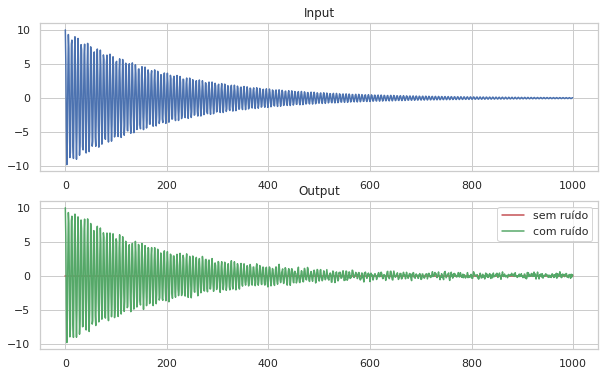

In [9]:
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

axes[0].set_title("Input")
axes[0].plot(t,UTRA,color='b')

axes[1].set_title("Output")
axes[1].plot(t,y,color='r',label='sem ruído')
axes[1].plot(t,YTRA,color='g',label='com ruído')
axes[1].legend(loc=1)

fig.savefig("funcoes.png",dpi=500, bbox_inches='tight')

In [10]:
# Novas constantes para validação
c = 2.01
m = 0.1
k = 10
zt = c/(2*np.sqrt(m*k))
print(zt)

1.005


In [11]:
# Função de Validação
u = np.array(uamp*np.exp(-zt*t)*np.exp(np.sqrt(zt**2-1)*t)).reshape((N,1))
y = np.array(np.zeros((N,1)))

In [12]:
UVAL = u
YVAL = u + sig*0.1*np.random.rand(N,1)

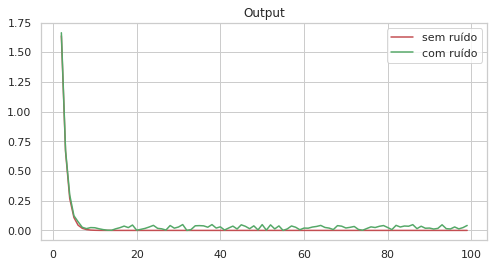

In [13]:
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Output")
axes.plot(t[2:100],UVAL[2:100],color='r',label='sem ruído')
axes.plot(t[2:100],YVAL[2:100],color='g',label='com ruído')
axes.legend(loc=1)

fig.savefig("funcoes-2.png",dpi=500, bbox_inches='tight')

Verificou-se que aumentando a ordem da entrada em 1, com o modelo ARX de ordem 2 na entrada e 3 na saída, houve melhora nos resultados.

In [14]:
Phi = np.concatenate((-YTRA[1:-1], -YTRA[0:-2], UTRA[1:-1], UTRA[0:-2]), axis=1)
PhiVAL = np.concatenate((-YVAL[1:-1], -YVAL[0:-2], UVAL[1:-1], UVAL[0:-2]), axis=1)
Y1 = YTRA[2:]
Y2 = YVAL[2:]

print(Phi.shape)

(998, 4)


In [15]:
# Precisa obter a pseudo inversa (pinv)
th_hat = np.dot(np.linalg.pinv(np.dot(Phi.conj().transpose(),Phi)), \
                np.dot(Phi.conj().transpose(),Y1))

In [16]:
yhat_TRA_OSA = np.dot(Phi,th_hat)
yhat_VAL_OSA = np.dot(PhiVAL,th_hat)

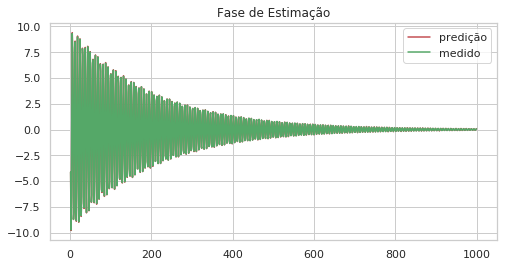

In [17]:
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Fase de Estimação")
axes.plot(t[2:],yhat_TRA_OSA,color='r',label='predição')
axes.plot(t[2:],UTRA[2:],color='g',label='medido')
axes.legend(loc=1)

fig.savefig("resultado_training.png",dpi=500, bbox_inches='tight')

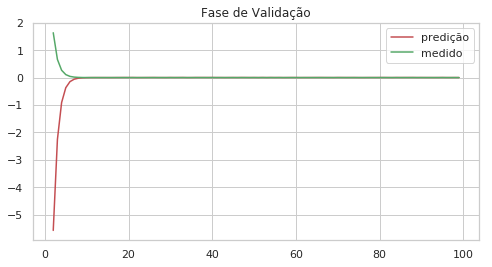

In [18]:
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Fase de Validação")
axes.plot(t[2:100],yhat_VAL_OSA[0:98],color='r',label='predição')
axes.plot(t[2:100],UVAL[2:100],color='g',label='medido')
axes.legend(loc=1)

fig.savefig("resultado_validate.png",dpi=500, bbox_inches='tight')

In [19]:
def plot_xcorrel(e,u):
    N = len(u)

    conf_factor = 1.96/np.sqrt(N)
    lag_vec = np.arange(0, N)
    
    conf = np.array([np.ones(len(lag_vec))*conf_factor, \
                     -1*np.ones(len(lag_vec))*conf_factor])
    
    EE = np.correlate(e,e, "same")
    UE = np.correlate(u,e, "same")
    EEU = np.correlate(e[0:-1], e[1:]*u[1:], "same")
    
    U2 = np.power(u,2) # element-wise power
    
    U2E = np.correlate(U2 - np.mean(U2),e, "same")
    U2E2 = np.correlate(U2 - np.mean(U2), \
                        np.power(e,2), "same")
    
    fig,axes = plt.subplots(nrows=5, ncols=1, figsize=(10,6))

    axes[0].plot(lag_vec,EE,color='b')
    axes[0].plot(lag_vec,conf[0],color='r',linestyle='--')
    axes[0].plot(lag_vec,conf[1],color='r',linestyle='--')
    axes[0].set_ylabel(r'$\phi_{\xi\xi}(\tau)$')
    axes[0].set_ylim([-1,1])
    axes[0].set_xticklabels([])
    
    axes[1].plot(lag_vec,UE,color='b')
    axes[1].plot(lag_vec,conf[0],color='r',linestyle='--')
    axes[1].plot(lag_vec,conf[1],color='r',linestyle='--')
    axes[1].set_ylabel(r'$\phi_{u\xi}(\tau)$')
    axes[1].set_ylim([-1,1])
    axes[1].set_xticklabels([])

    axes[2].plot(lag_vec[:-1],EEU,color='b')
    axes[2].plot(lag_vec[:-1],conf[0][1:],color='r',linestyle='--')
    axes[2].plot(lag_vec[:-1],conf[1][1:],color='r',linestyle='--')
    axes[2].set_ylabel(r'$\phi_{\xi(\xi u)}(\tau)$')
    axes[2].set_ylim([-1,1])
    axes[2].set_xticklabels([])

    axes[3].plot(lag_vec,U2E,color='b')
    axes[3].plot(lag_vec,conf[0],color='r',linestyle='--')
    axes[3].plot(lag_vec,conf[1],color='r',linestyle='--')
    axes[3].set_ylabel(r'$\phi_{(u^2) \xi}(\tau)$')
    axes[3].set_ylim([-1,1])
    axes[3].set_xticklabels([])
    
    axes[4].plot(lag_vec,U2E2,color='b')
    axes[4].plot(lag_vec,conf[0],color='r',linestyle='--')
    axes[4].plot(lag_vec,conf[1],color='r',linestyle='--')
    axes[4].set_ylabel(r'$\phi_{(u^2) \xi^2}(\tau)$')
    axes[4].set_ylim([-1,1])
    
    fig.savefig("resultado-corr.png",dpi=500, bbox_inches='tight')

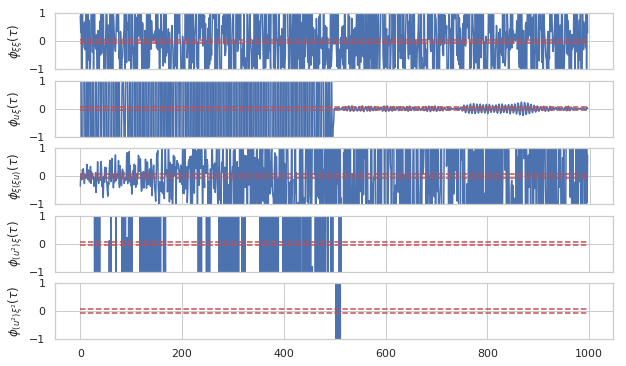

In [20]:
plot_xcorrel(Y1[:,0]-yhat_TRA_OSA[:,0], UTRA[2:,0])

In [ ]:
plot_xcorrel(Y2[:,0]-yhat_VAL_OSA[:,0], UTRA[2:,0])